In [2]:
import pandas as pd
from surprise import SVD, Reader, Dataset
import mlmetrics as metrics
import recmetrics

In [3]:
df_review = pd.read_pickle('../data/clean/reviews_Philadelphia_2015_2020.pkl')

AttributeError: 'Axes' object has no attribute 'set_yaxis'

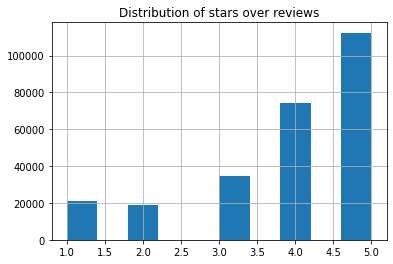

In [14]:
ax = df_review.review_stars.hist()
ax.set_title("Distribution of stars over reviews")
ax.set_yaxis("asd")

In [41]:
import pandas as pd
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split
import mlmetrics as metrics
import recmetrics


def split_train_test(df_review: pd.DataFrame, date: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the interactions based on the date
    """
    # if multiple reviews from the same user to a given business, select only the most recent
    df_review = df_review.sort_values(by="review_date").drop_duplicates(
        subset=['business_id', 'user_id'], keep='last')
    # split by date
    df_train = df_review[df_review['review_date']
                         < date].drop(columns='review_date')
    df_test = df_review[df_review['review_date']
                        >= date].drop(columns='review_date')
    # we select only users and businesses on test data that exist in the training data so that we don't suffer from the cold start problem
    df_test = df_test[(df_test['user_id'].isin(df_train['user_id'].unique())) &
                      (df_test['business_id'].isin(df_train['business_id'].unique()))]

    return df_train, df_test


def train_test_split_surprise(df_review: pd.DataFrame, factor: float):
    """
    """
    # maintain order by date
    df_review.sort_values(by='review_date', inplace=True)
    relevant_cols = ["user_id", "business_id", "review_stars"]
    # transform in surprise dataset
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(df_review[relevant_cols], reader)
    # split x% to test
    trainset, testset = train_test_split(dataset, shuffle=False, test_size=factor)
    return trainset, testset


def get_user_top_n(matrix: pd.DataFrame, user_id: str, top: int = 10):
    """
    function from: https://github.com/statisticianinstilettos/recmetrics/blob/master/example.ipynb
    """
    recommended_items = pd.DataFrame(matrix.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values(
        'predicted_rating', ascending=False)
    recommended_items = recommended_items.head(top)
    return recommended_items.index.tolist()


def get_recommendations(data: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    """
    # create matrix of predicted values
    data_matrix = data.pivot_table(
        index='user_id', columns='business_id', values='predictions').fillna(0)
    # mean user predictions
    data_lst = data.groupby('user_id', as_index=False)['business_id'].agg(
        {'actual': (lambda x: list(set(x)))}).set_index("user_id")
    # make recommendations for all members in the data
    recs = []
    for user in data.index:
        predictions = get_user_top_n(data_matrix, user, n)
        recs.append(predictions)
    data_lst['recommendations'] = recs

    return data_lst


def train_evaluate_svd(trainset: pd.DataFrame, testset: pd.DataFrame, n:int=10):
    """
    train and evaluate SVD (surprise lib)
    """
    # fit model
    algo = SVD(n_factors=20)
    algo.fit(trainset)

    # make predictions with lib
    test = pd.DataFrame(algo.test(testset))
    test.drop("details", inplace=True, axis=1)
    test.columns = ['user_id', 'business_id', 'actual', 'predictions']

    # get recommendations
    test_recs = get_recommendations(test, 10)

    # evaluate model
    print('-- SVD--')
    print(" MSE: ", recmetrics.mse(test['actual'], test['predictions']))
    print(" RMSE: ", recmetrics.rmse(test['actual'], test['predictions']))
    print(f" MAR@{n}: ", recmetrics.mark(test_recs['actual'].values.tolist(), test_recs['recommendations'].values.tolist(), k=n))
    # print(f" MAP@{n}: ", metrics.map_at_k(test_recs['actual'].values.tolist(), test_recs['recommendations'].values.tolist(), k=n))


In [43]:
# read clean data
df_review = pd.read_pickle(f'../data/clean/reviews_Edmonton_2015_2020.pkl')

# split
trainset, testset = train_test_split_surprise(df_review, 0.25)

In [44]:
# fit model
algo = SVD(n_factors=20)
algo.fit(trainset)

In [45]:
# make predictions with lib
test = pd.DataFrame(algo.test(testset))
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'business_id', 'actual', 'predictions']

In [48]:
data_matrix = test.pivot_table(index='user_id', columns='business_id', values='predictions').fillna(0)

In [51]:
# mean user predictions
data_lst = test.groupby('user_id', as_index=False)['business_id'].agg({'actual': (lambda x: list(set(x)))}).set_index("user_id")

In [62]:
pd.read_pickle("../data/final/preds.pkl").sample(4)

,uid,iid,r_ui,est,details
8401,Rxmww5nPfQSADXK8B2B7qg,w7STzUTtrVoHSvqRbwMp4A,4.0,3.845573,{'was_impossible': False}
9673,OC5NfNnFunZusgzkwXUQEA,6HCuq-HhycCP6FAEOozybg,1.0,3.242676,{'was_impossible': False}
5735,r3QexFIhBXBT99canAgVEg,38gOYYqd3QQEBL-cmd0J4g,4.0,3.526207,{'was_impossible': False}
5342,uF6k8qb01zY5cJ65SkgS-Q,jIcQDdE9R3vJWDAYtMn3hg,2.0,3.687538,{'was_impossible': False}


In [64]:
recs = pd.read_pickle("../data/final/recs.pkl")

In [ ]:
recmetrics.mark(actual, cf_predictions, k=K)

In [59]:
# make recommendations for all members in the data
recs = []
for user in data_lst.index:
    print(user)
    predictions = get_user_top_n(data_matrix, user, 10)
    recs.append(predictions)
data_lst['recommendations'] = recs

--_H9j6ggxvqhh9nPofZwg
-0PQBNgYk5tNECnz0z8ZtA
-6bkYGD5J7szG0JAblLmIA
-9QrNxZ0l0cSbTYXPlsu_g
-AOHJ6Ur85pOI4MrMEx9Lw
-B12zSZcf--Pc5Vy8Nn_Kw
-BJIu6TWs26q2yxozPAbEg
-E6AHdTbPAFpJ63lkvuZrA
-LZbpuuubk_hJmbkCNZzww
-LzxdPlEoUFzeYGXYfbkHQ
-NEuiczvThLcv-kIawdigA
-Oer2os7LrtAagVuWSN1AQ
-TXEPi7jsyKI7vjeXt7y-A
-X3kQ8lPA4IadFccYVXE0A
-_DyOjmAPjY_-uzFaBuNYw
-_TBlZG9fbt1yHLcu8hS0A
-b-SEEnMtLpetoSuuQn_6Q
-cwoSUKPvN3Xp0fvNIdP8g
-e00H5DYOLtrHub80c6ERw
-g8nkLX6PGNDSgoy4YzjFA
-kdXh5zoaRmI2zWGDIZdZg
-pszfFYnvnv4zAOOZ6cpDw
-uM1ujzuJed-2QmFS-6Vog
-zHcPJdu9uBpmP_20uHsHg
00NbY_rbUqgX4YWB1DU_AA
08INRYuoSBEbfOwNkTNQMw
0BfFxGjnF7_3C955EfOQwA
0C4ccDiZlnW68ULoDKE3NA
0DE54avP8W1su4Zwg8af-A
0ENd1AIvSuHjpxZmGE7WEw
0EmnoUubRANjWm00ExwGYg
0F7XKtYzva8JElT9xq0Lcg
0H3GqXjDTcxLiT0Ey6TYwA
0KEuFPZqB8d3_KLIJmyAZQ
0LqdGQC40AJZVmsQIgWJ0g
0MB2eL2akwygkH8ezcijZw
0Rre4KvHe6kk-6wtyZGUkw
0S4kgS7dyiO7KVl7gdwYng
0Tsu6-uhw_w9Z3W0Xlnazg
0_nbEMQyU0C7K93oOARvkA
0arkRqfIBMLGhOlK--GDjA
0iUm3t4fctxDb0ecp9tQ3Q
0keSW7DWpHwdyxBoTAOrkQ
0p8j4bzkHd-

In [39]:
# evaluate model
print('-- SVD--')
    print(" MSE: ", recmetrics.mse(test['actual'], test['predictions']))
    print(" RMSE: ", recmetrics.rmse(test['actual'], test['predictions']))
    print(f" MAR@{n}: ", recmetrics.mark(test_recs['actual'].values.tolist(), test_recs['recommendations'].values.tolist(), k=n))

In [60]:
test_recs

NameError: name 'test_recs' is not defined

In [25]:
train_evaluate_svd(df_train, df_test, 10)

df_train[relevant_cols]

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'